In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [4]:
# ------------------------------
# 1. LOAD DAN PRA-PROSES DATA
# ------------------------------
df = pd.read_csv("ethPriceHistory.csv", sep=';')
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df['Vol.'] = df['Vol.'].str.replace(',', '')
df['Vol.'] = df['Vol.'].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')


In [5]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2016-03-10,11.75,11.20,11.85,11.07,0.0,4.91%
1,2016-03-11,11.95,11.75,11.95,11.75,180.0,1.70%
2,2016-03-12,12.92,11.95,13.45,11.95,830.0,8.12%
3,2016-03-13,15.07,12.92,15.07,12.92,1300.0,16.64%
4,2016-03-14,12.50,15.07,15.07,11.40,92180.0,-17.05%


In [6]:
# ------------------------------
# 2. FEATURE ENGINEERING
# ------------------------------
df['Price_lag1'] = df['Price'].shift(1)
df['Price_lag2'] = df['Price'].shift(2)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Open_lag1'] = df['Open'].shift(1)
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['MA3'] = df['Price'].rolling(window=3).mean().shift(1)
df['MA5'] = df['Price'].rolling(window=5).mean().shift(1)
df = df.dropna().reset_index(drop=True)

In [7]:
# ------------------------------
# 3. SPLIT & STANDARDISASI
# ------------------------------
features = ["Price_lag1", "Price_lag2", "Vol_lag1", "Open_lag1", "High_lag1", "Low_lag1", "MA3", "MA5"]
X = df[features]
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# ------------------------------
# 4. XGBOOST BASIC (REALISTIC)
# ------------------------------
print("\n" + "="*60)
print("5. TRAINING XGBOOST BASIC (REALISTIC)")
print("="*60)

xgb_basic = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=2,
    learning_rate=0.3,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=1.0,
    reg_lambda=1.0,
)

start_time = time.time()
xgb_basic.fit(X_train_scaled, y_train)
training_time_basic = time.time() - start_time
y_pred_basic = xgb_basic.predict(X_test_scaled)

mse_basic = mean_squared_error(y_test, y_pred_basic)
mae_basic = mean_absolute_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)
rmse_basic = np.sqrt(mse_basic)

y_range = y_test.max() - y_test.min()
mae_pct_base = (mae_basic / y_range) * 100
rmse_pct_base = (rmse_basic / y_range) * 100

print(f"  Training Time: {training_time_basic:.2f} sec")
print(f"  RMSE: ${rmse_basic:.4f} ({rmse_pct_base:.2f}%)")
print(f"  MAE:  ${mae_basic:.4f} ({mae_pct_base:.2f}%)")
print(f"  R²:   {r2_basic:.4f}")

# Evaluasi di data training (untuk cek overfitting)
y_train_pred_basic = xgb_basic.predict(X_train_scaled)
mse_train_basic = mean_squared_error(y_train, y_train_pred_basic)
mae_train_basic = mean_absolute_error(y_train, y_train_pred_basic)
r2_train_basic = r2_score(y_train, y_train_pred_basic)

print("\n--- Training Set Metrics (Basic XGBoost) ---")
print(f"  RMSE (Train): ${np.sqrt(mse_train_basic):.4f}")
print(f"  MAE  (Train): ${mae_train_basic:.4f}")
print(f"  R²   (Train): {r2_train_basic:.4f}")



5. TRAINING XGBOOST BASIC (REALISTIC)
  Training Time: 0.17 sec
  RMSE: $114.1457 (4.40%)
  MAE:  $80.8926 (3.12%)
  R²:   0.9723

--- Training Set Metrics (Basic XGBoost) ---
  RMSE (Train): $59.3342
  MAE  (Train): $33.4843
  R²   (Train): 0.9971


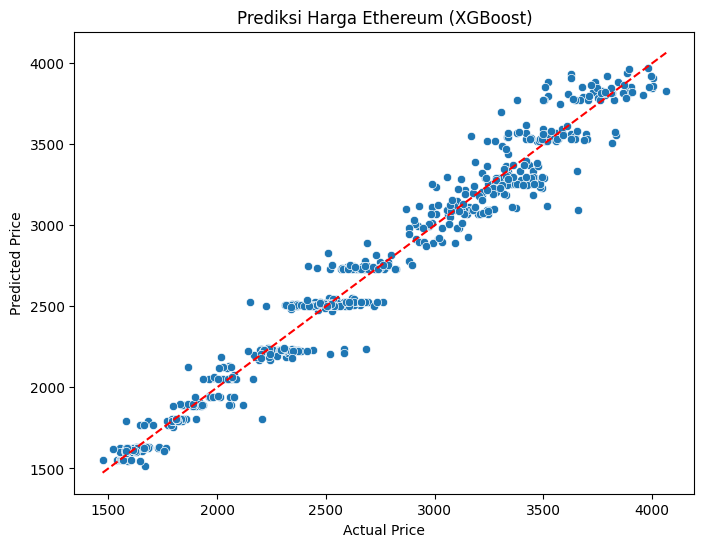

In [9]:
# ------------------------------
# 5. VISUALISASI PREDIKSI BASIC
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_basic)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Prediksi Harga Ethereum (XGBoost)")
plt.show()


In [10]:
# ------------------------------
# 6. XGBOOST + BAYESIAN OPTIMIZATION
# ------------------------------
print("\n" + "="*60)
print("6. TRAINING XGBOOST + BAYESIAN OPTIMIZATION")
print("="*60)

search_spaces = {
    'n_estimators': Integer(300, 500),
    'max_depth': Integer(3, 5),
    'learning_rate': Real(0.05, 0.1, prior='log-uniform'),
    'subsample': Real(0.7, 0.9),
    'colsample_bytree': Real(0.7, 0.9),
}
tscv = TimeSeriesSplit(n_splits=3)

opt = BayesSearchCV(
    estimator=XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ),
    search_spaces=search_spaces,
    cv=tscv,
    n_iter=25,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
opt.fit(X_train_scaled, y_train)
training_time_bayesian = time.time() - start_time

best_xgb = opt.best_estimator_
y_pred_bayesian = best_xgb.predict(X_test_scaled)

mse_bayes = mean_squared_error(y_test, y_pred_bayesian)
mae_bayes = mean_absolute_error(y_test, y_pred_bayesian)
r2_bayes = r2_score(y_test, y_pred_bayesian)
rmse_bayes = np.sqrt(mse_bayes)

mae_pct = (mae_bayes / y_range) * 100
rmse_pct = (rmse_bayes / y_range) * 100

print(f"\nXGBOOST + BAYESIAN OPTIMIZATION RESULTS:")
print(f"  Training Time: {training_time_bayesian:.2f} sec")
print(f"  RMSE: ${rmse_bayes:.4f} ({rmse_pct:.2f}%)")
print(f"  MAE:  ${mae_bayes:.4f} ({mae_pct:.2f}%)")
print(f"  R²:   {r2_bayes:.4f}")

print("\nOptimal parameters:")
for param, value in opt.best_params_.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

results = opt.cv_results_
best_index = np.argmax(results['mean_test_score'])  # karena menggunakan scoring negatif, semakin tinggi semakin baik
best_iteration = best_index + 1  # indeks dimulai dari 0, jadi tambahkan 1 agar menjadi iterasi ke-...

print(f"\nBest parameters found on iteration: {best_iteration} of 25")

# Evaluasi di data training (untuk cek overfitting)
y_train_pred_bayes = best_xgb.predict(X_train_scaled)
mse_train_bayes = mean_squared_error(y_train, y_train_pred_bayes)
mae_train_bayes = mean_absolute_error(y_train, y_train_pred_bayes)
r2_train_bayes = r2_score(y_train, y_train_pred_bayes)

print("\n--- Training Set Metrics (Bayesian Optimized XGBoost) ---")
print(f"  RMSE (Train): ${np.sqrt(mse_train_bayes):.4f}")
print(f"  MAE  (Train): ${mae_train_bayes:.4f}")
print(f"  R²   (Train): {r2_train_bayes:.4f}")



6. TRAINING XGBOOST + BAYESIAN OPTIMIZATION
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 f

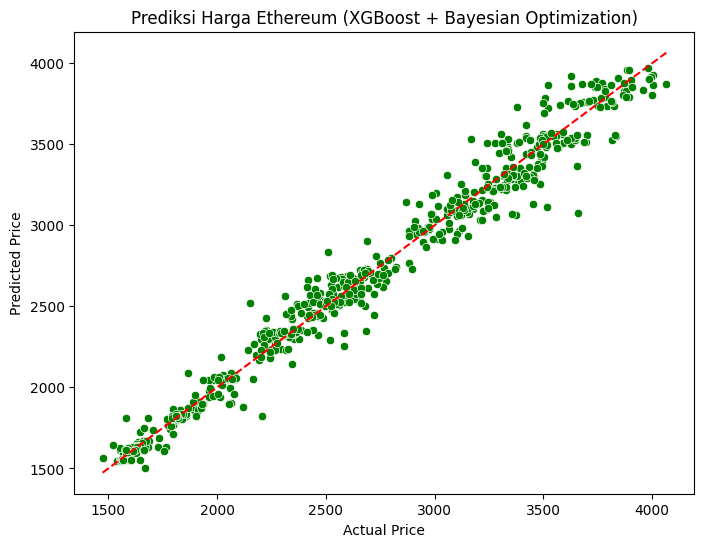

In [11]:
# ------------------------------
# 7. VISUALISASI PREDIKSI BAYESIAN
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_bayesian, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Prediksi Harga Ethereum (XGBoost + Bayesian Optimization)")
plt.show()

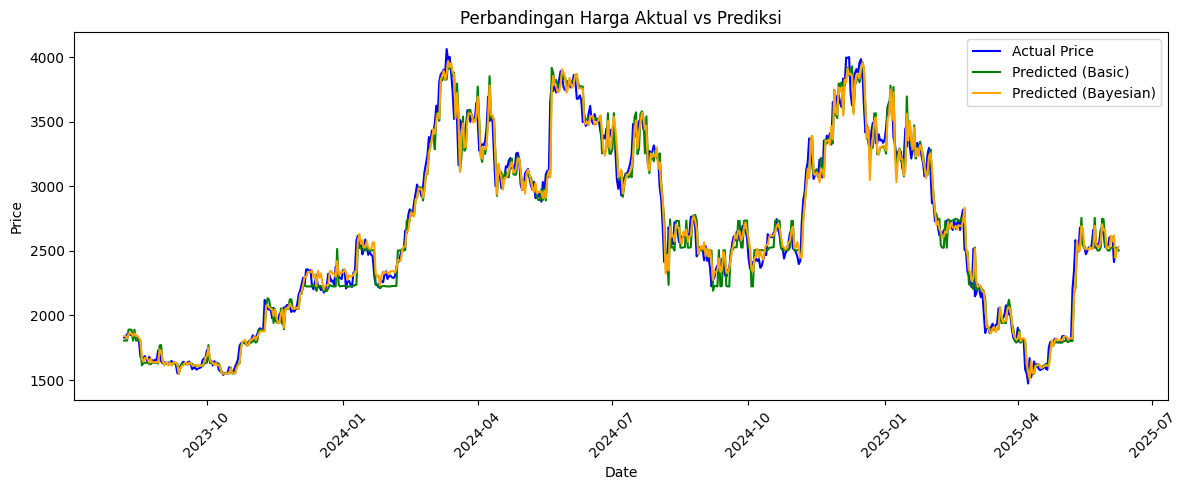

In [12]:
# ------------------------------
# 8. GRAFIK GARIS AKTUAL VS PREDIKSI
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(df['Date'].iloc[-len(y_test):], y_test.values, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_basic, label='Predicted (Basic)', color='green')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_bayesian, label='Predicted (Bayesian)', color='orange')
plt.title("Perbandingan Harga Aktual vs Prediksi")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()